# HMM Forecasting Walkthrough
### This notebook shows the step by step process of generating hmm forecasts along with forecast validation using simulated data.



## Setup
Load hmmTMB and other packages

In [15]:
library(devtools)
library(ggridges)
set.seed(1)

In [16]:

load_all("../../../hmmTMB")
#library(hmmTMB)

ℹ Loading hmmTMB


## Generate Data
Use the true model defined in true_mod.hmm to set the model functions.
Set arbitrary fixed effect coefficients.

In [17]:
# Simulate data -----------------------------------------------------------

# number of time steps
n <- 1000

# Generate training data with random covariates
empty <- data.frame(
  ID = 1, 
  pois_obs = rep(NA, n),
  norm_obs = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE)
  #random_effect_id = as.factor(rep(1:2, each = n/2))
)

# create true model
hid <- MarkovChain$new(
  data = empty,
  n_states = 2,
  formula = ~covariate_3,
  tpm = matrix(c(0.8, 0.3, 0.2, 0.7), 2, 2)
)
obs <- Observation$new(
  data = empty,
  dists = list(
    pois_obs = "pois",
    norm_obs = "norm"
  ),
  par = list(
    pois_obs = list(rate = c(1, 2)),
    norm_obs = list(mean = c(0, 1), sd = c(1, 1))
  ),
  formula = list(
    pois_obs = list(rate = ~ covariate_1),
    norm_obs = list(mean = ~ covariate_2)
  )
)
true_mod <- HMM$new(
  obs = obs,
  hid = hid
)

# Create a list of random integers for the hidden Markov model coefficients
random_coeff_fe_obs <- replicate(
  length(true_mod$coeff_list()$coeff_fe_obs),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)
random_coeff_re_obs <- replicate(
  length(true_mod$coeff_list()$coeff_re_obs),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)
random_log_lambda_obs <- replicate(
  length(true_mod$coeff_list()$log_lambda_obs),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)

# Update the coefficients of the hidden Markov model with the random values
true_mod$obs()$update_coeff_fe(coeff_fe = random_coeff_fe_obs)
true_mod$obs()$update_coeff_re(coeff_re = random_coeff_re_obs)
true_mod$obs()$update_lambda(random_log_lambda_obs)

random_coeff_fe_hid <- replicate(
  length(true_mod$coeff_list()$coeff_fe_hid),
  sample(c(0.9, 1, 1.1, 1.2), 1, replace = TRUE)
)
random_coeff_re_hid <- replicate(
  length(true_mod$coeff_list()$coeff_re_hid),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)
random_log_lambda_hid <- replicate(
  length(true_mod$coeff_list()$log_lambda_hid),
  sample(c(-0.1, 0, 0.1, 0.2), 1, replace = TRUE)
)

true_mod$hid()$update_coeff_fe(coeff_fe = random_coeff_fe_hid)
true_mod$hid()$update_coeff_re(coeff_re = random_coeff_re_hid)
true_mod$hid()$update_lambda(random_log_lambda_hid)

# View the model parameters
true_mod$coeff_list()


pois_obs.rate.state1.(Intercept),0.9
pois_obs.rate.state1.covariate_1,1.2
pois_obs.rate.state2.(Intercept),1.0
pois_obs.rate.state2.covariate_1,1.0
norm_obs.mean.state1.(Intercept),0.9
norm_obs.mean.state1.covariate_2,1.1
norm_obs.mean.state2.(Intercept),1.1
norm_obs.mean.state2.covariate_2,0.9
norm_obs.sd.state1.(Intercept),1.1
norm_obs.sd.state2.(Intercept),0.9
S1>S2.(Intercept),1.2


Simulating states... 100%
Simulating pois_obs... 100%
Simulating norm_obs... 100%


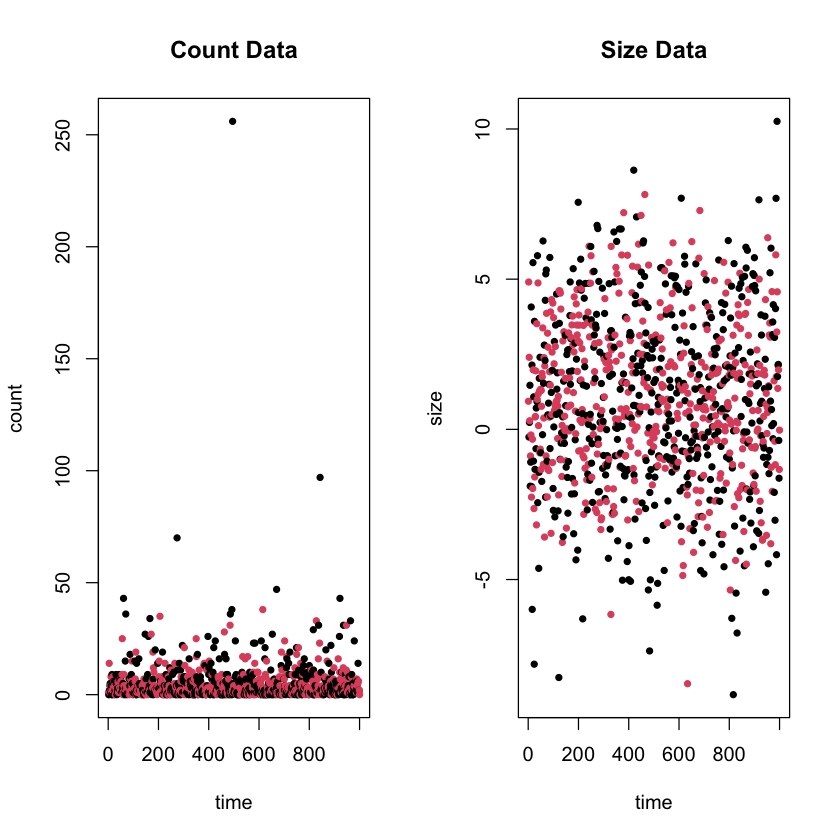

In [18]:
# simulate from true model
training <- true_mod$simulate(n, data = empty)

# update data in true_mod with dat
true_mod$obs()$update_data(training)

# plot data
par(mfrow = c(1, 2)) # set outer margins to 0
plot(training$pois_obs, pch = 20, xlab = "time", ylab = "count", col = attr(training, "state"), main = "Count Data")
plot(training$norm_obs, pch = 20, xlab = "time", ylab = "size", col = attr(training, "state"), main = "Size Data")
par(mfrow = c(1, 1))

## Fit the model 
Fit a model using the model definition and starting parameters defined by mod.hmm

In [19]:
# Fit model ------------------------------------------------------------

# create model to fit 
mod <- HMM$new(hid = hid, obs = obs)

# suggest better starting parameters
ini <- mod$suggest_initial()

# set to new starting parameters (or you could edit the specification file)
mod$obs()$update_par(ini)

# fit model
mod$fit(silent = TRUE)

Check that the model has converged and fit properly

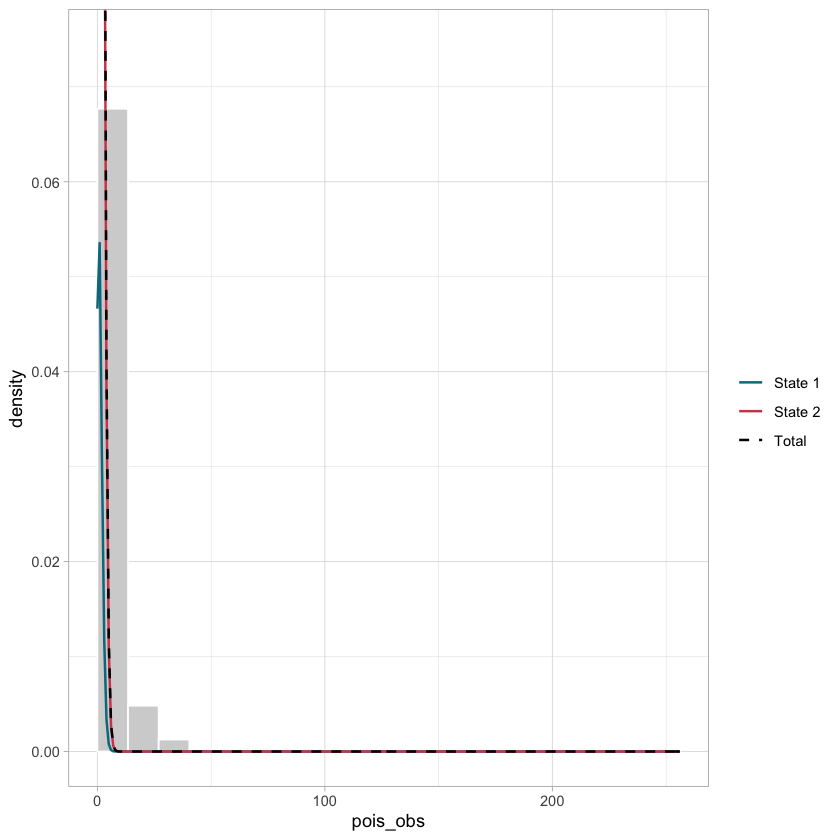

Computing CDFs... done
Computing residuals for pois_obs ... done
Computing residuals for norm_obs ... done


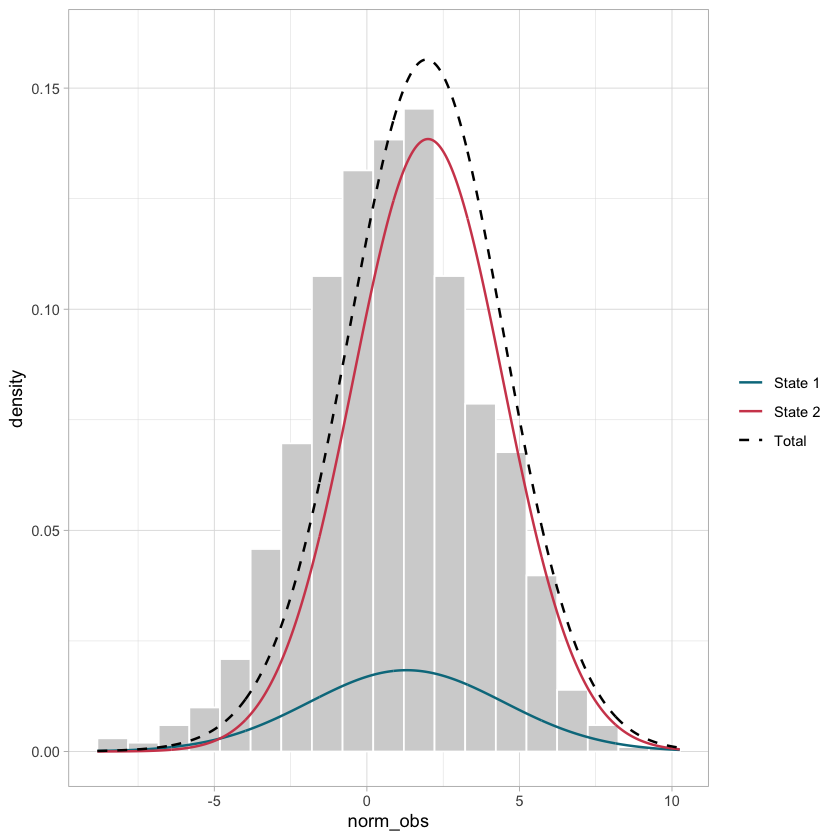

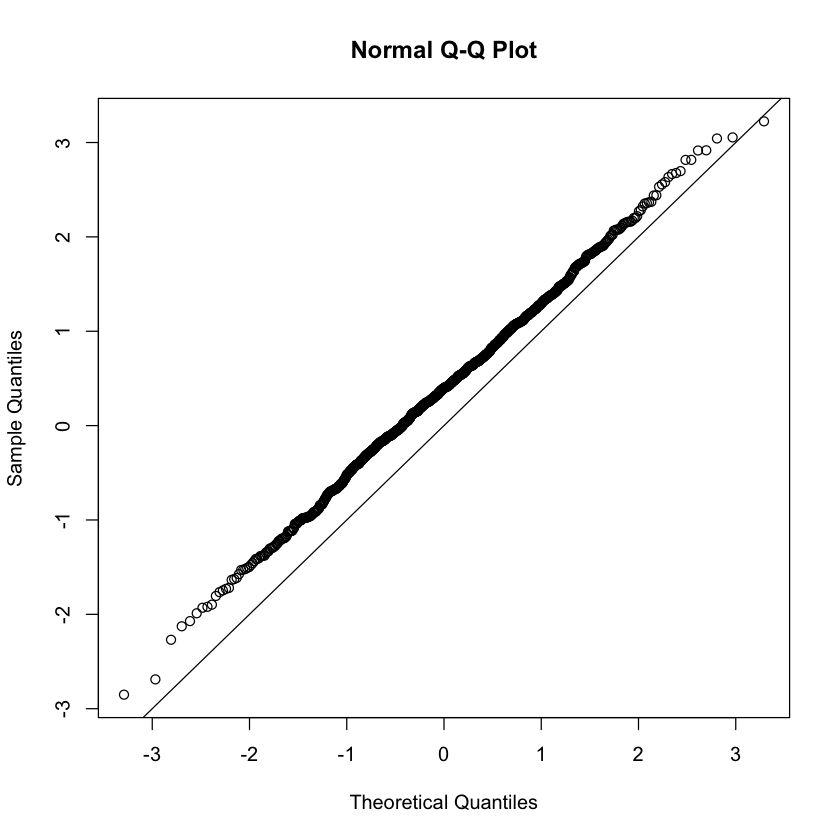

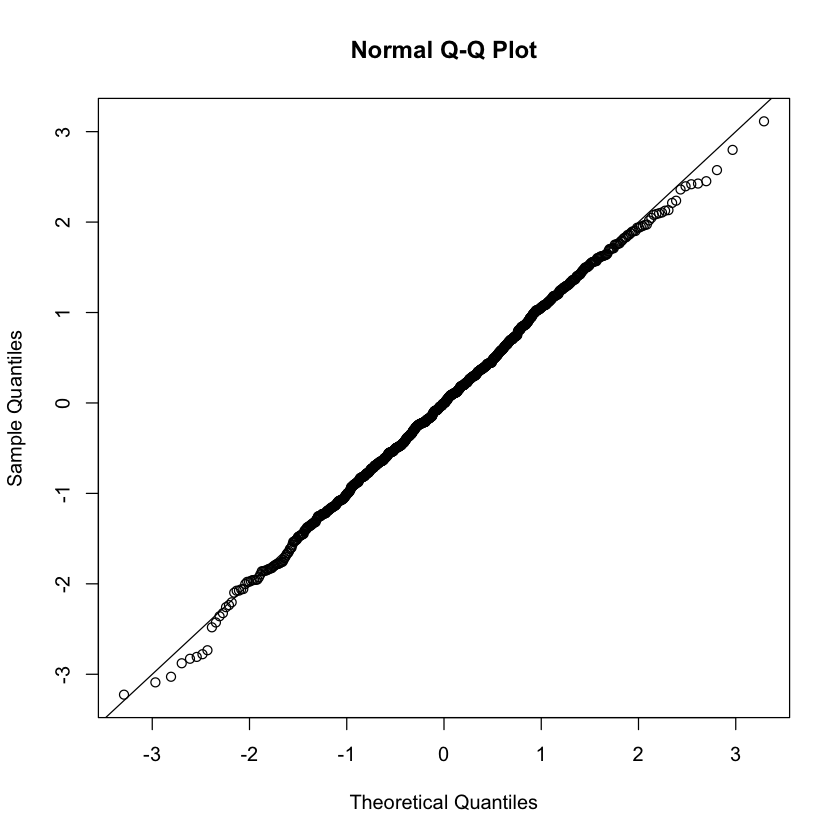

In [20]:
par(mfrow = c(1, 2))
mod$plot_dist("pois_obs")
mod$plot_dist("norm_obs")
par(mfrow = c(1, 1))

pr <- mod$pseudores()

qqnorm(pr$pois_obs)
abline(0, 1)

qqnorm(pr$norm_obs)
abline(0, 1)


## Forecasting
Use the fitted model to generate a probability distribution for each future state.

Set the number of future time steps to predict.
Calculate the parameter values at future time steps accounting for covariates using the predict method

In [21]:
# Set number of observations to predict
n <- 10

# Create new data for prediction, optionally with covariates
forecast_data <- data.frame(
  ID = 1, 
  pois_obs = rep(NA, n),
  norm_obs = rep(NA, n),
  covariate_1 = rnorm(n, mean = 0, sd = 1),
  covariate_2 = runif(n, min = -1, max = 1),
  covariate_3 = sample(c(-1, 0, 1), n, replace = TRUE)
  # random_effect_id = as.factor(rep(1:2, each = n/2))
)

forecast_data

ID,pois_obs,norm_obs,covariate_1,covariate_2,covariate_3
<dbl>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>
1,NA,NA,-0.27225030,0.2506252,1
1,NA,NA,-0.71720824,0.8678033,0
1,NA,NA,-0.19532618,-0.2374188,1
1,NA,NA,1.31326420,0.5469202,0
1,NA,NA,0.01268243,0.3950817,-1
1,NA,NA,-1.12421159,0.8369966,-1
1,NA,NA,0.85662803,-0.7556111,1
1,NA,NA,0.31418212,0.7315667,-1
1,NA,NA,0.33667190,0.7975774,1


In [22]:
## Generate forecast predictions using forecast module
eval_range <- list(
  pois_obs = 0:50,
  norm_obs = seq(-10, 10, by = 0.1)
)
forecasts <- Forecast$new(
  hmm = mod,
  forecast_data = forecast_data,
  preset_eval_range = eval_range,
  starting_state_distribution = "last"
)
forecasts

<Forecast>
  Public:
    clone: function (deep = FALSE) 
    eval_range: function () 
    forecast_data: function () 
    forecast_dists: function () 
    hidden_state_forecast: function () 
    initialize: function (hmm = NULL, n = NULL, forecast_data = NULL, preset_eval_range = NULL, 
    obs_par_forecast: function () 
    tpm_forecast: function () 
    update_eval_range: function (eval_range) 
  Private:
    configure_eval_range: function (eval_range = NULL, obs_vars = NULL, data = NULL) 
    eval_range_: list
    forecast_data_: data.frame
    forecast_dists_: list
    hidden_state_forecast_: 0.308420771001174 0.691579228998976 0.13647823595194 0.8 ...
    hmm_: HMM, R6
    obs_par_forecast_: 1.76463149083606 1.01295621035596 3.18990795839716 2.117 ...
    observation_vars_: pois_obs norm_obs
    starting_state_distribution_: last
    tpm_forecast_: 0.369199094883535 0.032692662687036 0.630800905116465 0. ...
    validate_params: function (hmm = NULL, n = NULL, forecast_data = NULL

### Plot the forecasted PDFs

Generate a ridge plot to show the probability distribution for each time step.
The plot shows every second time step to help declutter the plot.

In [25]:
forecasts$eval_range()

$pois_obs
 [1]  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
[26] 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
[51] 50

$norm_obs
  [1] -10.0  -9.9  -9.8  -9.7  -9.6  -9.5  -9.4  -9.3  -9.2  -9.1  -9.0  -8.9
 [13]  -8.8  -8.7  -8.6  -8.5  -8.4  -8.3  -8.2  -8.1  -8.0  -7.9  -7.8  -7.7
 [25]  -7.6  -7.5  -7.4  -7.3  -7.2  -7.1  -7.0  -6.9  -6.8  -6.7  -6.6  -6.5
 [37]  -6.4  -6.3  -6.2  -6.1  -6.0  -5.9  -5.8  -5.7  -5.6  -5.5  -5.4  -5.3
 [49]  -5.2  -5.1  -5.0  -4.9  -4.8  -4.7  -4.6  -4.5  -4.4  -4.3  -4.2  -4.1
 [61]  -4.0  -3.9  -3.8  -3.7  -3.6  -3.5  -3.4  -3.3  -3.2  -3.1  -3.0  -2.9
 [73]  -2.8  -2.7  -2.6  -2.5  -2.4  -2.3  -2.2  -2.1  -2.0  -1.9  -1.8  -1.7
 [85]  -1.6  -1.5  -1.4  -1.3  -1.2  -1.1  -1.0  -0.9  -0.8  -0.7  -0.6  -0.5
 [97]  -0.4  -0.3  -0.2  -0.1   0.0   0.1   0.2   0.3   0.4   0.5   0.6   0.7
[109]   0.8   0.9   1.0   1.1   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9
[121]   2.0   2.1   2.2   2.3   2.4   2.5   2.6   2.7   2.8   2.9   3.0   3.1
[133]   3.2   3.3   3.4   3.5   3.6   3.7   3.8   3.9   4.0   4.1   4.2   4.3
[145]   4.4   4.5   4.6   4.7   4.8   4.9   5.0   5.1   5.2   5.3   5.4   5.5
[157]   5.6   5.7   5.8   5.9   6.0   6.1   6.2   6.3   6.4   6.5   6.6   6.7
[169]   6.8   6.9   7.0   7.1   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9
[181]   8.0   8.1   8.2   8.3   8.4   8.5   8.6   8.7   8.8   8.9   9.0   9.1
[193]   9.2   9.3   9.4   9.5   9.6   9.7   9.8   9.9  10.0

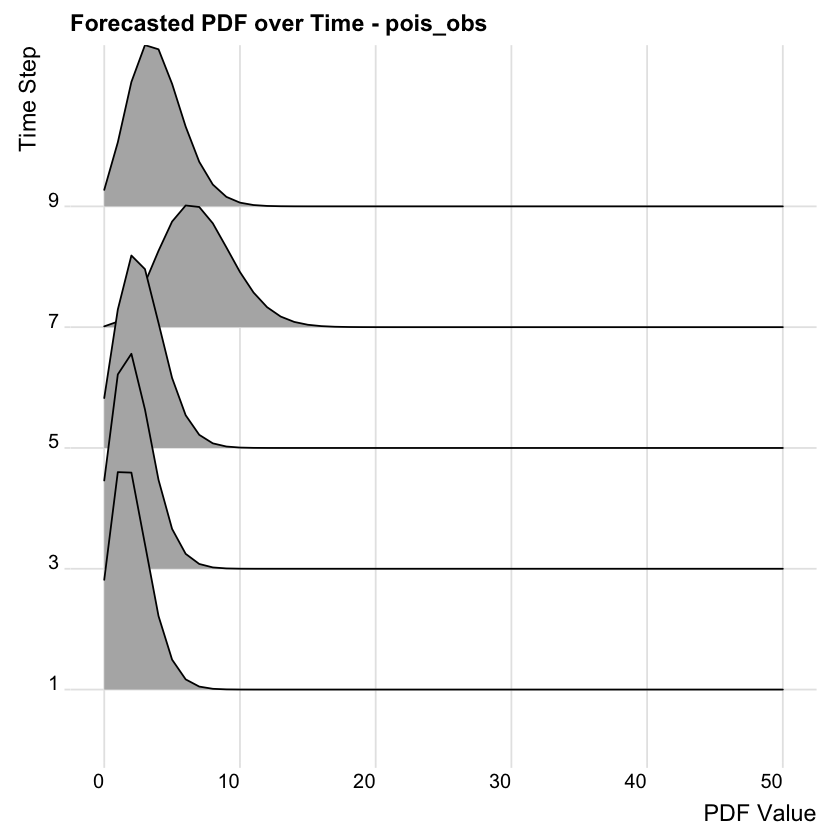

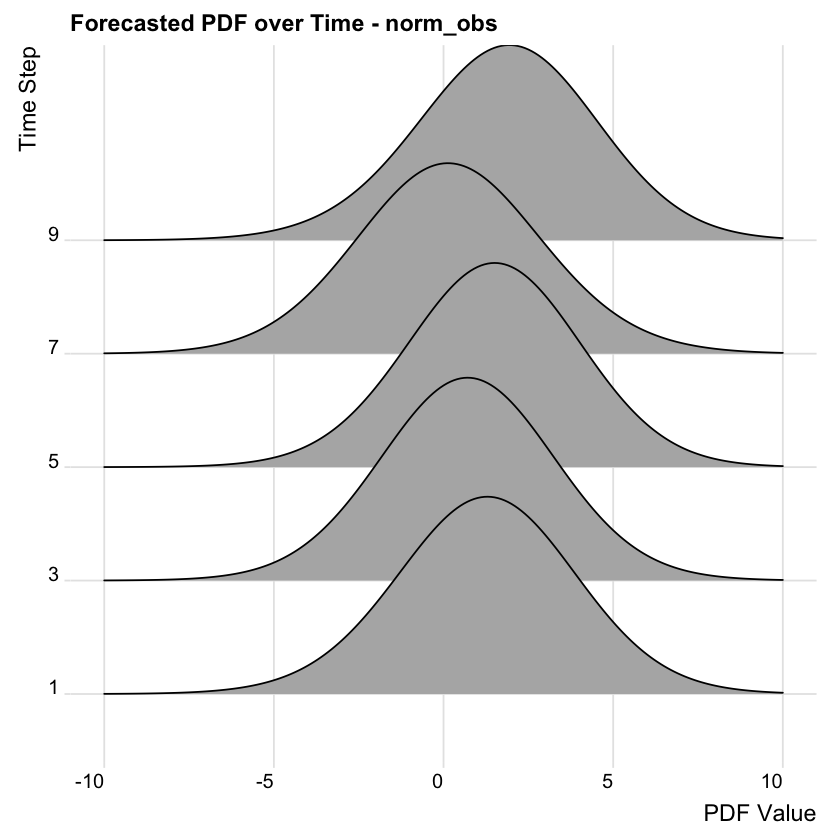

In [32]:
n_steps <- nrow(forecasts$forecast_data())
plot_steps <- seq(1, n_steps, by = 2)

obs_vars <- colnames(mod$obs()$obs_var())
for (obs in obs_vars) {
  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(
      forecasts$eval_range()[[obs]],
      times = length(plot_steps)
    ),
    y = as.vector(forecasts$forecast_dists()[[obs]][ , plot_steps]),
    time = factor(rep(plot_steps, each = length(forecasts$eval_range()[[obs]])))
  )
    
  print(ggplot(ridge_data, aes(x = x, y = time, height = y, group = time)) +
    geom_density_ridges(stat = "identity", position = "identity") +
    labs(x = "PDF Value", y = "Time Step", title = paste("Forecasted PDF over Time -", obs)) +
    theme_ridges() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 1)))
}


## Validate

Create 1000 simulations of the true model using the ending state and the same covariates used in forecasting.

In [31]:
n_dimensions <- length(obs_vars)
n_simulations <- 1000

# Get last hidden state
true_last_state <- tail(attr(true_mod$obs()$data(), "state"), 1) # last state
# get TPM of last observation
last_tpm <- true_mod$hid()$tpm(nrow(true_mod$obs()$data()))[, , 1]

# Update delta0 to use distribution of first forecasted state
true_mod$hid()$update_delta0(last_tpm[true_last_state, ])

# Initialize a named list of 2D arrays to store the simulation results
simulated_data <- list()
for (obs in obs_vars) {
  simulated_data[[obs]] <- array(NA, dim = c(n_simulations, n_steps))
}

# Simulate data and store it in the array
for (i in 1:n_simulations) {
  sim <- true_mod$simulate(n = n_steps, data = forecast_data, silent = TRUE)

  for (dimension in obs_vars) {
    # Get the simulated data for the current dimension
    simulated_data[[dimension]][i, ] <- sim[[dimension]]
  }
}

# Optionally, print a subset of the simulated data
print(simulated_data[[1]][1:5, ]) # Print the first 5 simulations


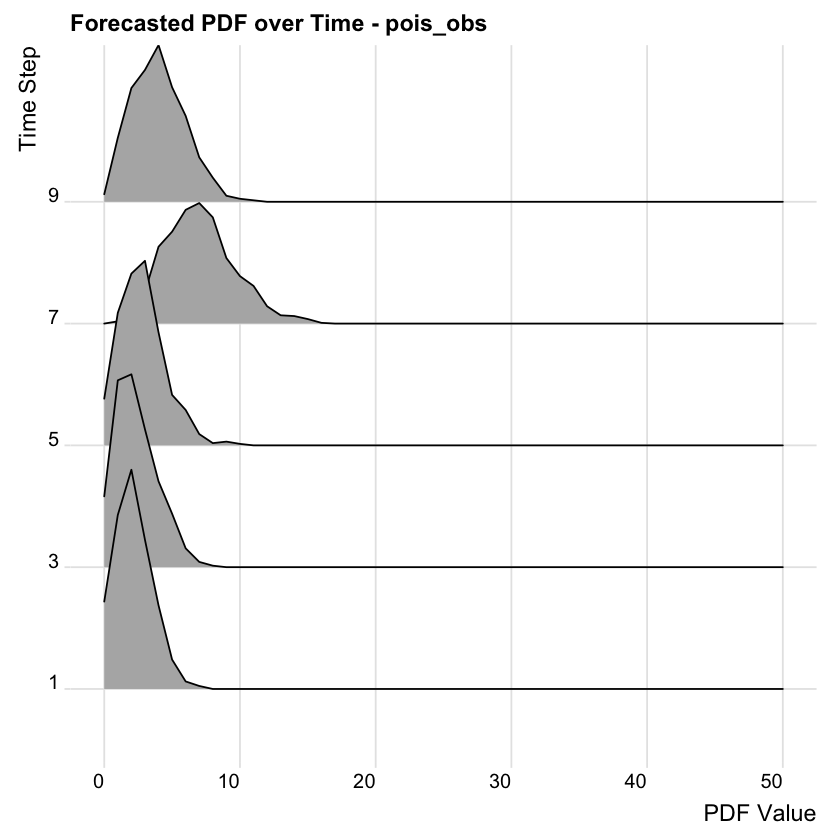

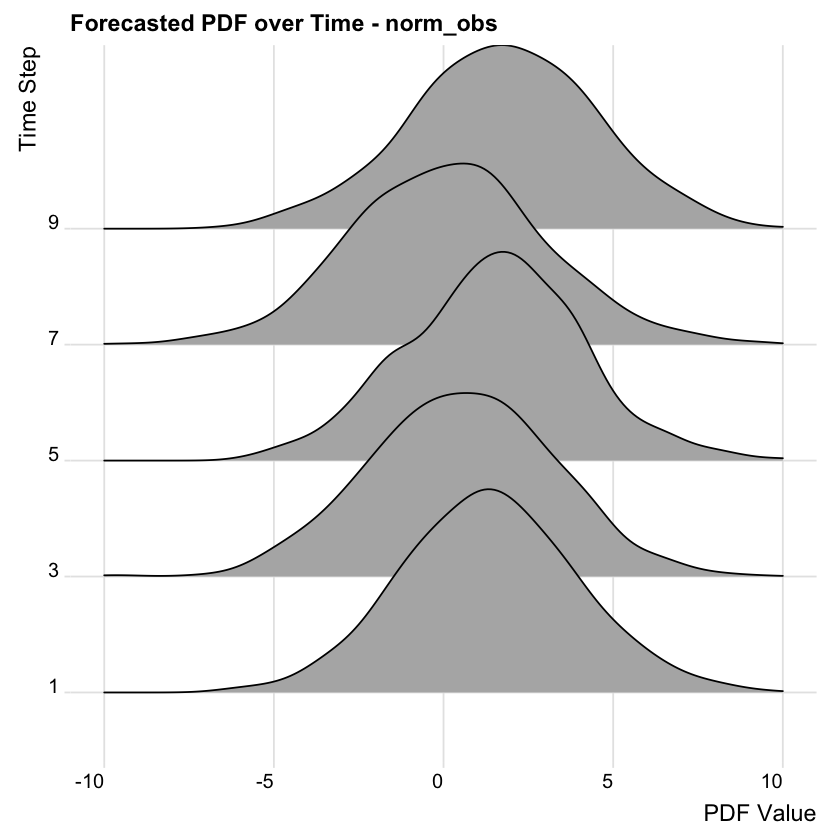

In [38]:
# Convert simulated data to a histogram at each time step
discrete_pdf <- function(sample_mat, eval_range) {
  apply(sample_mat, 2, function(col) {
    col <- as.numeric(col)
    counts <- table(factor(col, levels = eval_range))
    as.numeric(counts) / length(col)
  })
}

kde_simple <- function(x, eval_range, bw) {
  x <- as.numeric(x)
  dens <- density(x,
                  from   = min(eval_range),
                  to     = max(eval_range),
                  n      = length(eval_range),
                  bw     = "SJ",
                  cut    = 0,
                  kernel = "gaussian")
  dens$y
}

kde_pdf <- function(sample_mat, eval_range, bw) {
  apply(sample_mat, 2, function(col) {
    col <- as.numeric(col)
    kde_simple(col, eval_range, bw)
  })
}

simulated_pdfs <- vector("list", length(obs_vars))
names(simulated_pdfs) <- names(obs_vars)
for (obs in obs_vars) {
  eval_range <- forecasts$eval_range()[[obs]]
  bw <- diff(eval_range)[1]
  if (bw == 1) {
    # discreet case
    simulated_pdfs[[obs]]  <- discrete_pdf(simulated_data[[obs]], eval_range)
  } else {
    simulated_pdfs[[obs]] <- kde_pdf(simulated_data[[obs]], eval_range, bw)
  }

}
# Plot the simulated data as a ridge plot
for (obs in obs_vars) {
  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(
      forecasts$eval_range()[[obs]],
      times = length(plot_steps)
    ),
    y = as.vector(simulated_pdfs[[obs]][ , plot_steps]),
    time = factor(rep(plot_steps, each = length(forecasts$eval_range()[[obs]])))
  )
    
  print(ggplot(ridge_data, aes(x = x, y = time, height = y, group = time)) +
    geom_density_ridges(stat = "identity", position = "identity") +
    labs(x = "PDF Value", y = "Time Step", title = paste("Forecasted PDF over Time -", obs)) +
    theme_ridges() + 
    theme(axis.text.x = element_text(angle = 0, hjust = 1)))
}

#### Compare forecasted PDFs with simulated PDFs

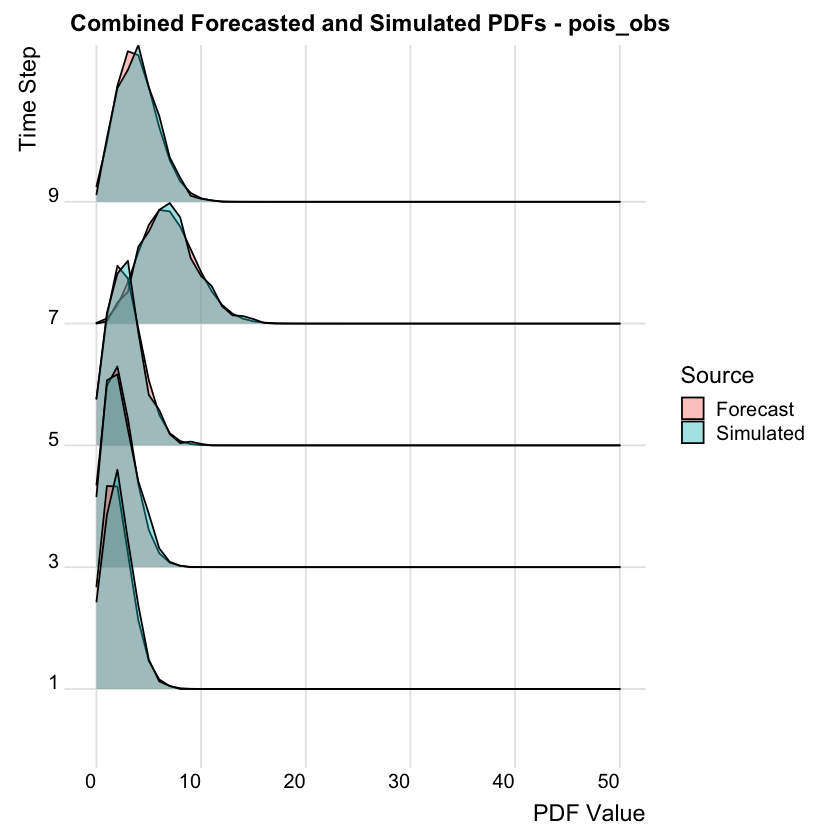

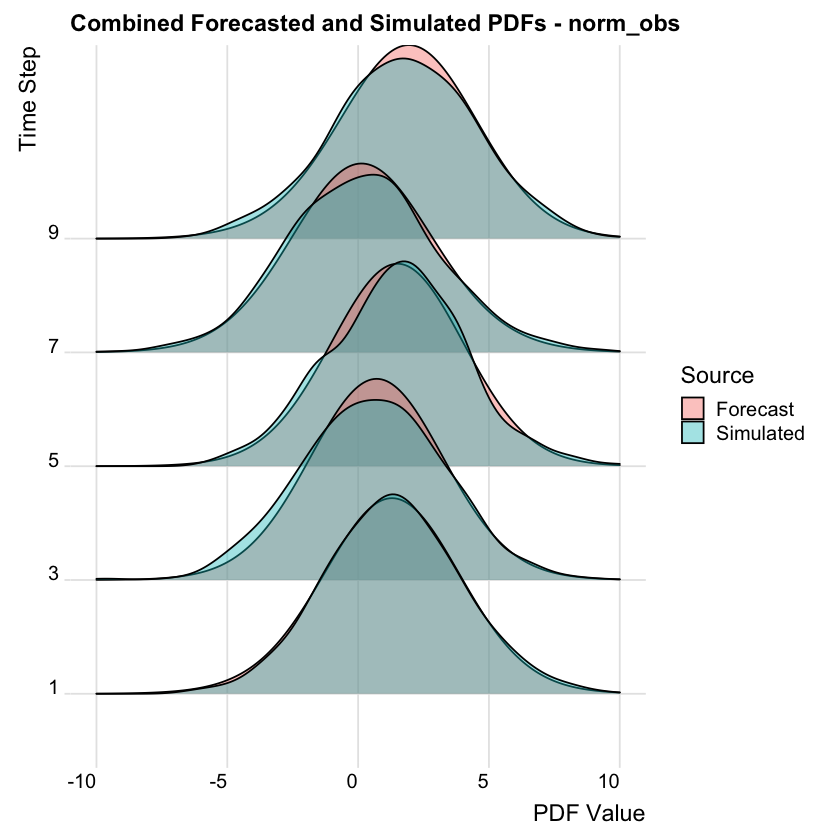

In [40]:
# Define the number of steps and the dimension to plot
n_steps <- nrow(forecasts$forecast_data())
plot_steps <- seq(1, n_steps, by = 2)  # Plot every second step for clarity

for (dimension in obs_vars) {
  # Get forecasted PDFs and simulated PDFs
  eval_range <- forecasts$eval_range()[[dimension]]
  forecast_pdfs <- forecasts$forecast_dists()[[dimension]]
  simulated_pdfs_dim <- simulated_pdfs[[dimension]]

  # Prepare data for ridge plot
  ridge_data <- data.frame(
    x = rep(eval_range, times = length(plot_steps) * 2),
    y = c(
      as.vector(forecast_pdfs[, plot_steps]),
      as.vector(simulated_pdfs_dim[, plot_steps])
    ),
    time = factor(rep(plot_steps, each = length(eval_range))),
    source = rep(c("Forecast", "Simulated"), each = length(eval_range) * length(plot_steps))
  )

  # Create the ridge plot
  print(
    ggplot(ridge_data, aes(x = x, y = time, height = y, group = interaction(time, source), fill = source)) +
      geom_density_ridges(stat = "identity", position = "identity", alpha = 0.4) +
      labs(
        x = "PDF Value",
        y = "Time Step",
        title = paste("Combined Forecasted and Simulated PDFs -", dimension),
        fill = "Source"
      ) +
      theme_ridges() +
      theme(axis.text.x = element_text(angle = 0, hjust = 1))
  )
}